In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input

from tqdm.notebook import trange

import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as ss

In [ ]:
import time

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import scipy.stats as ss

In [ ]:
from latentPosteriorEstimation.msgmm import MSGMM

In [ ]:
from sklearn.mixture import GaussianMixture

# Synthetic

In [ ]:

from scipy.stats import norm, uniform,dirichlet
from scipy.stats import multivariate_normal as mvn
import scipy.stats as stats

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from random import seed, randint, random
from sklearn import metrics
from matplotlib import pyplot as plt
from types import SimpleNamespace as SN
from sklearn.datasets import make_spd_matrix as spd

class mixture:

    def __init__(self, components, mixing_proportion):
        self.comps = components
        self.mixProp = mixing_proportion
        # self.sigmoid = activations.sigmoid()

    def pdf(self, x):
        return np.sum((p * comp.pdf(x) for (comp, p) in zip(self.comps, self.mixProp)), axis=1)

    def cdf(self, x):
        return np.sum((p * comp.cdf(x) for (comp, p) in zip(self.comps, self.mixProp)), axis=1)

    def rvs(self, size):
        sizes = np.cast['int32'](np.floor(size * self.mixProp))
        #pdb.set_trace()
        delta = np.cast['int32'](size - np.sum(sizes))
        ix = np.random.choice(np.size(self.mixProp), size=delta, p=self.mixProp)
        for ii in ix:
            sizes[ii] = sizes[ii] + 1
        dim = np.size(self.comps[0].rvs(size=1))
        x = np.empty([0, dim])
        for (s, comp) in zip(sizes, self.comps):
            new = comp.rvs(size=[s, 1])
            if len(new.shape) == 1:
                new = np.expand_dims(new,1)
            x = np.concatenate((x,new), axis=0)
        #pdb.set_trace()
        return x

    def rvsCompInfo(self, size):
        sizes = np.cast['int32'](np.floor(size * self.mixProp))
        #pdb.set_trace()
        delta = np.cast['int32'](size - np.sum(sizes))
        ix = np.random.choice(np.size(self.mixProp), size=delta, p=self.mixProp)
        for ii in ix:
            sizes[ii] = sizes[ii] + 1
        dim = np.size(self.comps[0].rvs(size=1))
        x = np.empty([0, dim])
        y = np.empty([0, 1])
        k = 0
        for (s, comp) in zip(sizes, self.comps):
            new = comp.rvs(size=[s, 1])
            print(x.shape, new.shape)
            x = np.concatenate((x, new), axis=0)
            y = np.concatenate((y, np.zeros([s, 1]) + k), axis=0)
            k = k + 1
        #pdb.set_trace()
        return x, y

    def component_pdfs(self, x):
        return (comp.pdf(x) for comp in self.comps)

class DataGenerator:

    def __init__(self, dist_p, dist_n, alpha, n_p, n_u, batch_size=1024):
        self.dist_p = dist_p
        self.dist_n = dist_n
        self.alpha = alpha
        self.n_p = n_p
        self.n_u = n_u
        self.n_up = np.cast['int32'](np.floor(n_u * alpha))
        self.n_un = self.n_u - self.n_up
        self.batch_size = batch_size

    @classmethod
    def _shuffle_in_unison(self, a, b):
        p = np.random.permutation(len(a))
        return a[p],b[p]
        
    def data_pos(self, n):
        #pdb.set_trace()
        return np.reshape(self.dist_p.rvs(size=n), newshape=(n, -1))


    def data_neg(self, n):
        return np.reshape(self.dist_n.rvs(size=n), newshape=(n, -1))

    def data_pos_compInfo(self, n):
        #pdb.set_trace()
        x, c = self.dist_p.rvsCompInfo(size=n)
        x = np.reshape(x, newshape=(n, -1))
        return x, c

    def data_neg_compInfo(self, n):
        x, c = self.dist_n.rvsCompInfo(size=n)
        x = np.reshape(x, newshape=(n, -1))
        return x, c

    def data_ul(self, n, alpha):
        n_up = np.cast['int32'](np.floor(n * alpha))
        n_un = n - n_up
        x_up = self.data_pos(n_up)
        x_un = self.data_neg(n_un)
        x = np.concatenate((x_up, x_un), axis=0)
        y = np.zeros([n, 1])
        y[np.arange(x_up.shape[0]), 0] = 1
        return x, y

    def pu_data(self):
        x_p = self.data_pos(self.n_p)
        x_u, y_u = self.data_ul(self.n_u, self.alpha)
        x_pu = np.concatenate((x_p, x_u), axis=0)
        y_pu = np.zeros([x_pu.shape[0], 1])
        y_pu[np.arange(self.n_p), 0] = 1
        y_pn = np.concatenate((np.ones([self.n_p, 1]), y_u), axis=0)
        # y_pn = y_pu
        # y_pn[x_pu.size(0):(self.n_p - 1):-1, 0] = y_u
        return x_pu, y_pu, y_pn
        
    def pn_data(self, n, alpha):
        "return x,y"
        x_p = self.data_pos(int(alpha*n))
        x_n = self.data_neg(int((1-alpha)*n))
        y_p = np.ones((len(x_p), 1))
        y_n = np.zeros((len(x_n), 1))
        x = np.vstack((x_p, x_n))
        y = np.vstack((y_p, y_n))
        x, y = self._shuffle_in_unison(x, y)
        return x, y

    def pn_data_compInfo(self, n, alpha):
        x_p, c_p = self.data_pos_compInfo(int(alpha*n))
        x_n, c_n = self.data_neg_compInfo(int((1-alpha)*n))
        y_p = np.ones((len(x_p), 1))
        y_n = np.zeros((len(x_n), 1))
        x = np.vstack((x_p, x_n))
        y = np.vstack((y_p, y_n))
        c = np.vstack((c_p, c_n))
        return x, y, c
    
    def dens_pos(self, x):
        return self.dist_p.pdf(x)

    def dens_neg(self, x):
        return self.dist_n.pdf(x)

    def dens_mix(self, x, a):
        return a * self.dens_pos(x) + (1 - a) * self.dens_neg(x)

    def pn_posterior(self, x, a):
        return a * self.dens_pos(x) / self.dens_mix(x, a)

    def pu_posterior(self, x):
        c1 = self.n_p / (self.n_u + self.n_p)
        c2 = (self.n_up + self.n_p) / (self.n_u + self.n_p)
        return c1 * self.dens_pos(x) / self.dens_mix(x, c2)

    def pn_posterior_sts(self, x):
        c = (self.n_up + self.n_p) / (self.n_u + self.n_p)
        return self.pn_posterior(x, c)

    def pn_posterior_cc(self, x):
        return self.pn_posterior(x, self.alpha)

    def pn_posterior_balanced(self, x):
        return self.pn_posterior(x, 0.5)


class GaussianDG(DataGenerator):

    def __init__(self, mu, sig, alpha, n_p, n_u, batch_size=1024):
        dist_p = norm(loc=0, scale=1)
        dist_n = norm(loc=mu, scale=sig)
        super(GaussianDG, self).__init__(dist_p=dist_p, dist_n=dist_n, alpha=alpha, n_p=n_p, n_u=n_u, batch_size=batch_size)


class UniformDG(DataGenerator):

    def __init__(self, mu, sig, alpha, n_p, n_u, batch_size=1024):
        dist_p = uniform(loc=0, scale=1)
        dist_n = uniform(loc=mu, scale=sig)
        super(UniformDG, self).__init__(dist_p=dist_p, dist_n=dist_n, alpha=alpha, n_p=n_p, n_u=n_u, batch_size=batch_size)


class NormalMixDG(DataGenerator):

    def __init__(self, mu_pos, sig_pos, p_pos, mu_neg, sig_neg, p_neg, alpha, n_pos, n_ul, batch_size = 1024):
        components_pos = [norm(loc=mu, scale=sig) for (mu, sig) in zip(mu_pos, sig_pos)]
        components_neg = [norm(loc=mu, scale=sig) for (mu, sig) in zip(mu_neg, sig_neg)]
        dist_pos = mixture(components_pos, p_pos)
        dist_neg = mixture(components_neg, p_neg)
        super(NormalMixDG, self).__init__(dist_p=dist_pos, dist_n=dist_neg, alpha=alpha, n_p=n_pos, n_u=n_ul, batch_size=batch_size)


class MVNormalMixDG(DataGenerator):

    def __init__(self, mu_pos, sig_pos, p_pos, mu_neg, sig_neg, p_neg, alpha, n_pos, n_ul, batch_size = 1024):
        self.components_pos = [mvn(mean=mu, cov=sig) for (mu, sig) in zip(mu_pos, sig_pos)]
        self.components_neg = [mvn(mean=mu, cov=sig) for (mu, sig) in zip(mu_neg, sig_neg)]
        dist_pos = mixture(self.components_pos, p_pos)
        dist_neg = mixture(self.components_neg, p_neg)
        super(MVNormalMixDG, self).__init__(dist_p=dist_pos, dist_n=dist_neg, alpha=alpha, n_p=n_pos, n_u=n_ul, batch_size=batch_size)


class NormalMixParameters:

    def __init__(self, dim, max_comps, quiet=False):
        self.dim = dim
        self.max_comps = max_comps
        #self.n_comps_pos = randint(1, max_comps)
        #self.n_comps_neg = randint(1, max_comps)
        self.n_comps_pos = max_comps
        self.n_comps_neg = max_comps
        self.mu_pos = list()
        self.mu_neg = list()
        for i in np.arange(max(self.n_comps_pos, self.n_comps_neg)):
            mu = np.array([16/np.sqrt(self.dim) * random() - 8/np.sqrt(self.dim) for i in np.arange(self.dim)])
            if i < self.n_comps_pos:
                self.mu_pos.append(mu)
            if i < self.n_comps_neg:
                self.mu_neg.append(mu)
        #self.mu_pos = [np.zeros(dim) for j in np.arange(self.n_comps_pos)]
        #self.mu_neg = [np.zeros(dim) for j in np.arange(self.n_comps_neg)]
        self.sig_pos = [np.identity(dim) for j in np.arange(self.n_comps_pos)]
        self.sig_neg = [np.identity(dim) for j in np.arange(self.n_comps_neg)]
        self.p_pos = dirichlet(np.ones(self.n_comps_pos)).rvs([])
        #self.p_neg = dirichlet(np.ones(self.n_comps_neg)).rvs([])
        self.p_neg = self.p_pos
        #self.changeInfo = {'changed': False, 'positive': True, 'mu': True, 'ix':0, 'oldvalue': self.mu_pos[0]}
        self.changeInfo = {'changed': False}
        self.alpha = random()
        self.quiet = quiet

    def computePNDataMetrics(self):
        epsilon = 0.05
        n = 10000
        _, x, y, pos, neg, dg = self.generatePNData(n, n)
        posterior_pos = dg.pn_posterior_balanced(pos)
        irreducibility = np.mean(np.cast['int32'](posterior_pos > 1-epsilon).flatten())
        posterior_x = dg.pn_posterior_balanced(x)
        fpr, tpr, thresholds = metrics.roc_curve(y, posterior_x)
        aucpn = metrics.auc(fpr, tpr)
        #pdb.set_trace()
        return {'aucpn': aucpn, 'irreducibility': irreducibility}

    def createDataGenerator(self, n_pos, n_ul):
        dg = MVNormalMixDG(self.mu_pos, self.sig_pos, self.p_pos, self.mu_neg, self.sig_neg, self.p_neg, self.alpha,
                         n_pos, n_ul)
        return dg

    def generatePNData(self, n_pos, n_neg):
        dg = self.createDataGenerator(50, 500)
        pos = dg.data_pos(n_pos)
        neg = dg.data_neg(n_neg)
        y = np.concatenate((np.ones([n_pos, 1]), np.zeros([n_neg, 1])), axis=0)
        x = np.concatenate((pos, neg), axis=0)
        xy = np.concatenate((x, y), axis=1)
        #pdb.set_trace()
        return xy, x, y, pos, neg, dg

    def perturb2SatisfyMetrics(self, irr_range, aucpn_range):
        irr_mid = np.mean(irr_range, axis=0)
        aucpn_min = min_aucpn(irr_mid)
        # if aucpn_range[0] < aucpn_min:
        #    raise ValueError('Irreducibility range and AUCPN range are not compatible:\n',
        #                      'AUCPN should be above', aucpn_min, 'for midpoint irreducibility of', irr_mid)
        while not self.isMetricSatisfied(irr_range, aucpn_range):
            self.markRandomParForChange()
            #print(self.changeInfo)
            if self.muMarked():
                self.perturbMu(irr_range, aucpn_range)
            else:
                if self.pMarked():
                    self.perturbProportion(irr_range, aucpn_range)
                else:
                    if random() <= 1:
                        self.perturbSigmaShape(irr_range, aucpn_range)
                    else:
                        self.perturbSigmaScale(irr_range, aucpn_range)
            self.commitChange()

    def perturbMu(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Mu Perturb')
        c = 0.1
        delta = np.array([2 * random( ) - 1 for i in np.arange(self.dim)])
        delta = c * delta/np.linalg.norm(delta)
        mu = self.getMarkedParOldValue()
        up = 1.0
        self.proposeChange(mu + up * delta)
        while not self.isMetricUBSatisfied(irr_range, aucpn_range):
            up = up/2
            self.proposeChange(mu + up * delta)

    def perturbSigmaShape(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Sigma Shape Perturb')
        newsigma = spd(self.dim)
        sigma = self.getMarkedParOldValue()
        a = 0.1
        self.proposeChange((1-a) * sigma + a * newsigma)
        while not self.isMetricUBSatisfied(irr_range, aucpn_range):
            a = a/2
            self.proposeChange((1-a) * sigma + a * newsigma)

    def perturbSigmaScale(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Sigma Scale Perturb')
        sigma = self.getMarkedParOldValue()
        a = 1.5
        self.proposeChange(a * sigma)
        while not (self.isMetricUBSatisfied(irr_range, aucpn_range) and self.acceptableSigma(a * sigma)):
            a = 1 + (a - 1)/2
            #print(a)
            #print('metric:', self.isMetricUBSatisfied(irr_range, aucpn_range))
            #print('acceptable Sigma:', self.acceptableSigma(a * sigma) )
            self.proposeChange(a * sigma)

    def perturbProportion(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Perturb Proportion')
        prop = self.getMarkedParOldValue( )
        a = 0.25
        if self.changeInfo['is_positive']:
            prop_1 = dirichlet(np.ones(self.n_comps_pos)).rvs([])
        else:
            prop_1 = dirichlet(np.ones(self.n_comps_neg)).rvs([])
        new_prop = (1 - a) * prop + a * prop_1
        self.proposeChange(new_prop)
        while not (self.isMetricUBSatisfied(irr_range, aucpn_range)):
            a = a/2
            new_prop = (1 - a) * prop + a * prop_1
            # print(a)
            self.proposeChange(new_prop)

    def muMarked(self):
        return self.changeInfo['is_mu']

    def pMarked(self):
        return self.changeInfo['is_proportion']

    def acceptableSigma(self, sigma):
        det = np.linalg.det(sigma)
        ratios = np.array([det/np.linalg.det(sig) for sig in self.sig_pos + self.sig_neg])
        if not self.quiet:
            print(ratios)
        ratios[:] = 1
        return all(ratios > 0.25)

    def isMetricSatisfied(self, irr_range, aucpn_range):
        metrics = self.computePNDataMetrics()
        irr_satisfied = irr_range[0] <= metrics['irreducibility'] <= irr_range[1]
        auc_satisfied = aucpn_range[0] <= metrics['aucpn'] <= aucpn_range[1]
        if not self.quiet:
            print(metrics)
        return irr_satisfied and auc_satisfied

    def isMetricUBSatisfied(self, irr_range, aucpn_range):
        metrics = self.computePNDataMetrics()
        irr_satisfied = metrics['irreducibility'] <= irr_range[1]
        auc_satisfied = metrics['aucpn'] <= aucpn_range[1]
        return irr_satisfied and auc_satisfied

    def proposeChange(self, newValue):
        self.changeInfo['changed'] = True
        V = SN(**self.changeInfo)
        self.updatePar(V.is_positive, V.is_mu, V.is_proportion, V.ix, newValue)

    def commitChange(self):
        self.changeInfo = {'changed': False}

    def updatePar(self, is_positive, is_mu, is_proportion, ix, newValue):
        if is_positive:
            if is_mu:
                self.mu_pos[ix] = newValue
            else:
                if is_proportion:
                    self.p_pos = newValue
                else:
                    self.sig_pos[ix] = newValue
        else:
            if is_mu:
                self.mu_neg[ix] = newValue
            else:
                if is_proportion:
                    self.p_neg = newValue
                else:
                    self.sig_neg[ix] = newValue

    def markRandomParForChange(self):
        if self.changeInfo['changed']:
            raise ValueError('Attempting to change a new parameter before committing the previous one')
        is_positive = random() < 0.5
        rr = random()
        is_mu = rr < 1.0/3.0
        is_proportion = 1.0/3.0 <= rr <= 2.0/3.0
        ix = np.nan
        if is_positive:
            ix = randint(0, self.n_comps_pos - 1)
            if is_mu:
                value = self.mu_pos[ix]
            else:
                if is_proportion:
                    value = self.p_pos
                else:
                    value = self.sig_pos[ix]
        else:
            ix = randint(0, self.n_comps_neg - 1)
            if is_mu:
                value = self.mu_neg[ix]
            else:
                if is_proportion:
                    value = self.p_neg
                else:
                    value = self.sig_neg[ix]

        self.changeInfo.update({'is_positive': is_positive, 'is_mu': is_mu, 'is_proportion': is_proportion, 'ix': ix, 'oldValue': value})

    def getMarkedParOldValue(self):
        return self.changeInfo['oldValue']

    def revert2OldValue(self):
        V = SN(**self.changeInfo)
        self.updatePar(V.is_positive, V.is_mu, V.ix, V.oldValue)
        self.changeInfo['changed'] = False
        return

def min_aucpn(irreducibility):
    return irreducibility + (1-irreducibility)/2

def GaussianMixtureDataGenerator(dim, n_comps, aucpn_range, n_p, n_u, irreducibility_range=[0.1,1]):
    NMix = NormalMixParameters(dim, n_comps,quiet=True)
    NMix.perturb2SatisfyMetrics(irreducibility_range, aucpn_range)
    dg = NMix.createDataGenerator(n_p, n_u)
    return dg



In [ ]:
from sklearn.model_selection import train_test_split

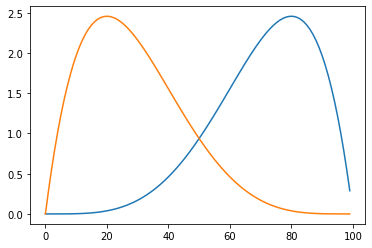

In [ ]:
plt.plot(ss.beta.pdf(np.arange(0,1,.01),a=5,b=2))
plt.plot(ss.beta.pdf(np.arange(0,1,.01),a=2,b=5))

In [ ]:
# dim = 1
# n_comps = 1
# aucpn_range = [0.5, 0.85]
# n_p = 5000
# n_u = 20000
# dg = GaussianMixtureDataGenerator(dim, n_comps, aucpn_range, n_p, n_u,irreducibility_range=[.01,1])
# x, y, y_p = dg.pu_data()
NLP=1000
NUP = 5000
NN = 5000
classPrior = NUP / (NUP + NN)
f0 = ss.beta(a=2,b=5)
f1 = ss.beta(a=5,b=2)
posterior = lambda x: classPrior * f1.pdf(x) / (classPrior * f1.pdf(x) + (1 - classPrior) * f0.pdf(x))
xUnlabeled = np.concatenate((f0.rvs(NN),f1.rvs(NUP)))[:,None]
yPN = np.concatenate((np.zeros(NN),
                    np.ones(NUP))).astype(bool)
xPos = f1.rvs(NLP)[:,None]
xPosTrain, xPosVal = train_test_split(xPos,test_size=.1)
xUnlabeledTrain,xUnlabeledVal,yPNTrain,yPNVal = train_test_split(xUnlabeled,yPN,test_size=.1)

<ipython-input-113-93486b05c4f3>:14: RuntimeWarning: invalid value encountered in true_divide
  posterior = lambda x: classPrior * f1.pdf(x) / (classPrior * f1.pdf(x) + (1 - classPrior) * f0.pdf(x))


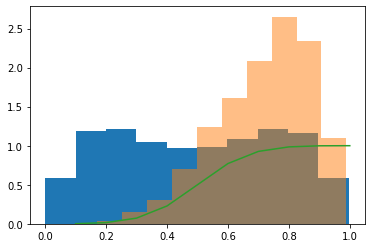

In [ ]:
plt.hist(xUnlabeled,density=True)
plt.hist(xPos,density=True,alpha=.5)
rng = np.arange(-6,6,.1)
plt.plot(rng, posterior(rng))

In [ ]:
class AdversarialAutoencoder:
    def __init__(self, input_shape, h_dim, z_dim, ae_loss_weight, gen_loss_weight, dc_loss_weight):
        self.input_shape = input_shape
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.ae_loss_weight = ae_loss_weight
        self.gen_loss_weight = gen_loss_weight
        self.dc_loss_weight = dc_loss_weight
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.mse = tf.keras.losses.MeanSquaredError()
        self.accuracy = tf.keras.metrics.BinaryAccuracy()
        self.makeModel()
        

    def makeEncoder(self,):
        inputs = tf.keras.Input(shape=(self.input_shape,))
        x = tf.keras.layers.Dense(self.h_dim)(inputs)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(self.h_dim)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        encoded = tf.keras.layers.Dense(self.z_dim)(x)
        self.encoder = tf.keras.Model(inputs=inputs, outputs=encoded)
        
    def makeDecoder(self):
        encoded = tf.keras.Input(shape=(self.z_dim,))
        x = tf.keras.layers.Dense(self.h_dim)(encoded)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(self.h_dim)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        reconstruction = tf.keras.layers.Dense(self.input_shape, activation=None)(x)
        self.decoder = tf.keras.Model(inputs=encoded, outputs=reconstruction)
        
    def makeDiscriminator(self):
        encoded = tf.keras.Input(shape=(self.z_dim,))
        x = tf.keras.layers.Dense(self.h_dim)(encoded)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(self.h_dim)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        prediction = tf.keras.layers.Dense(1)(x)
        self.discriminator = tf.keras.Model(inputs=encoded, outputs=prediction)
        
    def makeModel(self):
        self.makeEncoder()
        self.makeDecoder()
        self.makeDiscriminator()
    
    def autoencoder_loss(self, inputs, reconstruction):
        return self.ae_loss_weight * self.mse(inputs, reconstruction)


    def discriminator_loss(self, real_output, fake_output):
        loss_real = self.cross_entropy(tf.ones_like(real_output), real_output)
        loss_fake = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return self.dc_loss_weight * (loss_fake + loss_real)


    def generator_loss(self, fake_output):
        return self.gen_loss_weight * self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def makeOptimizers(self, base_lr):
        self.ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        
    @tf.function
    def aeTrainStep(self,batch_x):
        # Autoencoder
        with tf.GradientTape() as ae_tape:
            encoder_output = self.encoder(batch_x, training=True)
            decoder_output = self.decoder(encoder_output, training=True)

            # Autoencoder loss
            ae_loss = self.autoencoder_loss(batch_x, decoder_output)
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        self.ae_losses.append(ae_loss)

    @tf.function
    def discriminatorTrainStep(self, batch_x):
        # Discriminator
        with tf.GradientTape() as dc_tape:
            real_distribution = tf.reshape(tf.map_fn(lambda x: tf.random.normal([int(batch_x.shape[0] / len(self.m)),],
                                                                               mean=x[0],
                                                                               stddev=x[1]),
                                                    tf.cast(tf.concat([tf.reshape(self.m,(-1,1)),
                                                               tf.reshape(tf.sqrt(self.s), (-1,1))],
                                                              axis=1),tf.float32), dtype=tf.float32),
                                          (-1,self.z_dim))
            encoder_output = self.encoder(batch_x, training=True)

            dc_real = self.discriminator(real_distribution, training=True)
            dc_fake = self.discriminator(encoder_output, training=True)

            # Discriminator Loss
            dc_loss = self.discriminator_loss(dc_real, dc_fake)

            # Discriminator Acc
            dc_acc = self.accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                              tf.concat([dc_real, dc_fake], axis=0))

        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))
        # Log Loss and Accuracy
        self.dc_losses.append(dc_loss)
        self.dc_accs.append(dc_acc)

    @tf.function
    def generatorTrainStep(self, batch_x):
        # Generator (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encoder(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=True)

            # Generator loss
            gen_loss = self.generator_loss(dc_fake)

        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))
        # Log Loss
        self.gen_losses.append(gen_loss)

    @tf.function
    def train_step(self, batch_x):
        self.aeTrainStep(batch_x)
        self.discriminatorTrainStep(batch_x)
        self.generatorTrainStep(batch_x)
     
    def updateMeans(self,):
        embeddingsU = self.encoder(self.xUnlabeled, training=False).numpy()
        embeddingsP = self.encoder(self.xPos,training=False).numpy()
        self.em = MSGMM()
        self.em.fit(embeddingsU, embeddingsP,verbose=True,iterations=50)
        self.m = np.concatenate((self.em.u0,
                                 self.em.u1))
        self.s = np.concatenate((self.em.sigma0,
                                 self.em.sigma1))
        
    def plot(self,):
        X = np.concatenate((self.xUnlabeledVal,self.xPosVal))
        embeddings = self.encoder(X,training=False).numpy()
        resp = self.em.predict_proba(embeddings)
        
#         predPost = resp[:,1] * .5 / (resp[:,1] * .5 + resp[:,0] * .5)
        predPost = resp * self.em.alpha / (resp * self.em.alpha + (1-resp) * (1-self.em.alpha))
        plt.scatter(predPost,posterior(X))
        plt.show()

    def fit(self,xUnlabeled, xPos,validation_data=(np.array([]),np.array([])), n_epochs=100, batch_size=32):
        # Make Dataset
        # Create the dataset iterator
        self.xUnlabeled = xUnlabeled
        self.xPos = xPos
        train_buf = 60000
        train_dataset = tf.data.Dataset.from_tensor_slices(np.concatenate((xUnlabeled,
                                                                           xPos)))
        train_dataset = train_dataset.shuffle(buffer_size=train_buf)
        train_dataset = train_dataset.batch(batch_size)
        (self.xUnlabeledVal, self.xPosVal) = validation_data
        # Define records
        self.ae_losses = []
        self.dc_losses = []
        self.dc_accs = []
        self.gen_losses = []
        # Initialize EM Algorithm
        self.m = np.zeros(2)
        self.s = np.ones(2)
        # Define cyclic learning rate
        base_lr = 0.00025
        max_lr = 0.0025
        batch_size=32
        n_samples = 60000
        step_size = 2 * np.ceil(len(train_dataset) / batch_size)
        global_step = 0
        self.makeOptimizers(base_lr)
        # Start Training
        for epoch in trange(n_epochs):
            start = time.time()

            # Learning rate schedule
            if epoch in [60, 100, 300]:
                base_lr = base_lr / 2
                max_lr = max_lr / 2
                step_size = step_size / 2

                print('learning rate changed!')

            epoch_ae_loss_avg = tf.metrics.Mean()
            epoch_dc_loss_avg = tf.metrics.Mean()
            epoch_dc_acc_avg = tf.metrics.Mean()
            epoch_gen_loss_avg = tf.metrics.Mean()

            for batch, (batch_x) in tqdm(enumerate(train_dataset),leave=False,total=len(train_dataset)):
                # -------------------------------------------------------------------------------------------------------------
                # Calculate cyclic learning rate
                global_step = global_step + 1
                cycle = np.floor(1 + global_step / (2 * step_size))
                x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
                clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
                self.ae_optimizer.lr = clr
                self.dc_optimizer.lr = clr
                self.gen_optimizer.lr = clr

                self.train_step(batch_x)

                epoch_ae_loss_avg(self.ae_losses[-1])
                epoch_dc_loss_avg(self.dc_losses[-1])
                epoch_dc_acc_avg(self.dc_accs[-1])
                epoch_gen_loss_avg(self.gen_losses[-1])

            epoch_time = time.time() - start
            print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
                  .format(epoch, epoch_time,
                          epoch_time * (n_epochs - epoch),
                          epoch_ae_loss_avg.result(),
                          epoch_dc_loss_avg.result(),
                          epoch_dc_acc_avg.result(),
                          epoch_gen_loss_avg.result()))
            self.updateMeans()
            self.plot()

In [ ]:
aae = AdversarialAutoencoder(x.shape[1], 64,1, 1,1,1)

   0: TIME: 17.34 ETA: 1733.92 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.0656211  0.06795334]]

0.28712577172684245 0.7138700022957291 [-0.76680107] [-0.73155184]

[[0.04448093 0.06534845]]

0.26572928613049107 0.9044480492589585 [-0.87917764] [-0.6778522]

[[0.01718323 0.05154745]]

0.2810278169663236 0.9670098840433576 [-0.97326364] [-0.62263955]

[[0.01234541 0.03504962]]

0.35032630112634067 0.8805064935677127 [-0.9932021] [-0.57728856]

[[0.01282337 0.02883171]]

0.3906456339668697 0.8887836326464715 [-0.98598178] [-0.55528722]

[[0.01408018 0.02564704]]

0.41936400580971944 0.9150153390893226 [-0.97632369] [-0.54074955]

[[0.0152553  0.02335063]]

0.4421668232679707 0.9346197497843496 [-0.96806535] [-0.52947535]

[[0.01626654 0.02166294]]

0.46007736654305265 0.948343356580527 [-0.96136692] [-0.52077905]

[[0.01710161 0.02042482]]

0.47393365769241874 0.957856164246156 [-0.95608252] [-0.51415349]

[[0.01777141 0.01951692]]

0.4845287496845061 0.964467847

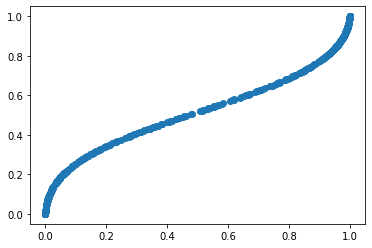

   1: TIME: 1.63 ETA: 161.02 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.00991887 0.01000075]]

0.2854878071422367 0.7123715859231214 [-0.23237485] [-0.21936708]

[[0.0066005  0.00971821]]

0.26449572193785714 0.9019873696801561 [-0.27581775] [-0.19872783]

[[0.00247305 0.00764728]]

0.2813816399102468 0.9647126293137073 [-0.31255123] [-0.17703539]

[[0.00176909 0.00516088]]

0.3521338885355832 0.8764956521005683 [-0.32011164] [-0.15928741]

[[0.00185515 0.00424457]]

0.392597703413211 0.887841301892728 [-0.31715084] [-0.1507769]

[[0.00204285 0.00376165]]

0.4215868254194496 0.9141619097102699 [-0.31340895] [-0.14508464]

[[0.00221625 0.00341569]]

0.444360331140992 0.9334771853821486 [-0.31024718] [-0.14071263]

[[0.00236416 0.00316496]]

0.46199879159572355 0.9469125456960769 [-0.30771212] [-0.13738698]

[[0.00248493 0.00298382]]

0.47543841901203815 0.9561791921919409 [-0.30573841] [-0.13489174]

[[0.00258053 0.00285312]]

0.4855516978583373 0.96259065626423

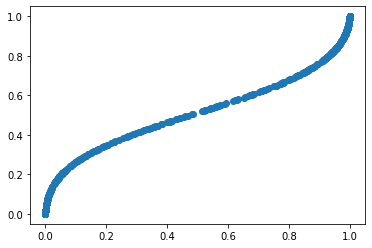

   2: TIME: 1.81 ETA: 177.04 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.00048748 0.00050599]]

0.2839448784815636 0.7130593543409507 [-0.00783306] [-0.00476752]

[[0.00028458 0.00050104]]

0.26499590956945607 0.9107270868987766 [-0.0179448] [7.5634911e-05]

[[0.00011905 0.00040077]]

0.28503829657515206 0.9697033721612756 [-0.02510358] [0.00453553]

[[8.72431760e-05 3.09392885e-04]]

0.33431421398778505 0.8877306692646909 [-0.02685175] [0.00742684]

[[8.27277719e-05 2.78524754e-04]]

0.3544551892440194 0.8662132851050569 [-0.02699972] [0.00846173]

[[8.44601094e-05 2.69541715e-04]]

0.36377754201713913 0.8726541476361628 [-0.0268227] [0.0088833]

[[8.64826184e-05 2.64255171e-04]]

0.37040950858355753 0.88027948205771 [-0.02664977] [0.00917127]

[[8.81830462e-05 2.60272738e-04]]

0.3755944206101061 0.8864448564442465 [-0.02650812] [0.0093947]

[[8.95679766e-05 2.57160570e-04]]

0.3797024748398748 0.8912886234312338 [-0.02639405] [0.0095712]

[[9.06897314e-05 2.5

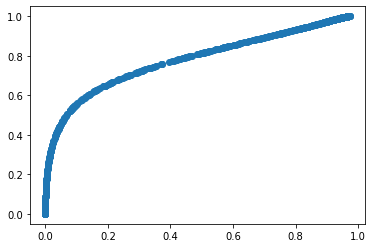

   3: TIME: 1.98 ETA: 192.07 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[2.60397108e-05 2.89128344e-05]]

0.28508974812353505 0.7163655918029185 [0.09375016] [0.0936584]

[[1.83871306e-05 3.22107814e-05]]

0.2861721520943056 0.7636617595724278 [0.09287113] [0.09408981]

[[1.35476676e-05 3.29867871e-05]]

0.336016153316108 0.7324649713429632 [0.09174873] [0.09483726]

[[9.09650921e-06 2.97350716e-05]]

0.4230590166565654 0.4584277602666671 [0.09060876] [0.09597612]

[[4.03145309e-06 2.23180414e-05]]

0.4409135917957057 0.2346157919334251 [0.08940789] [0.09681524]

[[1.08439170e-06 2.05795947e-05]]

0.36564432161613414 0.158372961223213 [0.08852304] [0.09643046]

[[3.02066186e-07 2.16695349e-05]]

0.3036265059193811 0.1138413233305563 [0.08812209] [0.09592178]

[[2.02490168e-07 2.23575041e-05]]

0.2801172406257288 0.09616505553318605 [0.08802675] [0.09571255]

[[1.74812009e-07 2.26233491e-05]]

0.2711441032627187 0.08981537621091386 [0.08799445] [0.09563352]

[[1.61

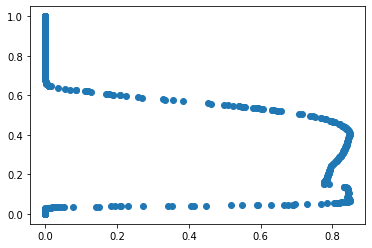

   4: TIME: 1.85 ETA: 177.16 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.00020516 0.00020225]]

0.2851689359624732 0.7093471005318489 [0.33835777] [0.33664465]

[[0.00019205 0.00017198]]

0.2690735835004972 0.8774093342978664 [0.34446505] [0.33371082]

[[0.00011552 0.00011416]]

0.28998321641099195 0.9671967912821942 [0.35002645] [0.33024517]

[[6.65359616e-05 4.18844522e-05]]

0.39274663626988404 0.8856422577736802 [0.35113894] [0.32635481]

[[8.12893261e-05 2.44172077e-05]]

0.4627819340883153 0.9309717359793379 [0.34934397] [0.32479207]

[[9.72215446e-05 1.75969889e-05]]

0.510210523400947 0.9701890787052214 [0.34794479] [0.32395776]

[[1.08104467e-04 1.43170051e-05]]

0.5413445134617749 0.9891905213674009 [0.34704236] [0.32349097]

[[1.14398613e-04 1.26948155e-05]]

0.5597851098306746 0.9969934137145116 [0.3465239] [0.32323954]

[[1.17619106e-04 1.19187731e-05]]

0.5695572858590393 0.9993880856103097 [0.34625695] [0.32311318]

[[1.19145819e-04 1.15590249e-05

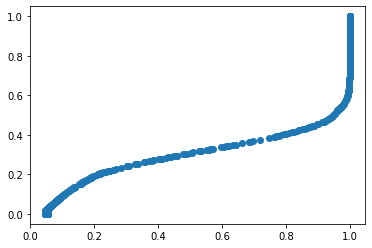

   5: TIME: 0.91 ETA: 86.33 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.0007456  0.00074917]]

0.2845937436367415 0.7144401213291021 [0.59945424] [0.5956582]

[[0.00064924 0.00067167]]

0.26557627807804746 0.8868099459926362 [0.61039813] [0.59046848]

[[0.00041281 0.00053791]]

0.2626871767602472 0.9781794615144481 [0.61972426] [0.58575359]

[[0.00028261 0.00034846]]

0.32274143021395474 0.9580635585780853 [0.6232774] [0.5806778]

[[0.0002597  0.00025191]]

0.38214144088783064 0.9179677095400619 [0.62248129] [0.5775115]

[[0.00027934 0.00021784]]

0.41885350055917603 0.9421799304375928 [0.62091374] [0.57588345]

[[0.00030102 0.00019614]]

0.447598004557061 0.9662300667889785 [0.61955463] [0.57469049]

[[0.00031954 0.0001805 ]]

0.4704816823453666 0.9819872599990686 [0.61847434] [0.57378142]

[[0.00033436 0.00016927]]

0.4881817818608604 0.9914158570816305 [0.61764726] [0.57310372]

[[0.0003456  0.00016133]]

0.5014164975157063 0.9965260123761014 [0.61703695] [0.

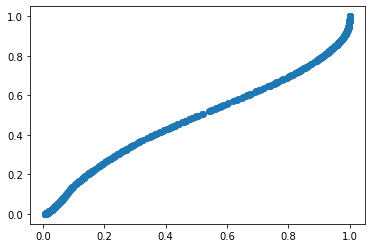

   6: TIME: 1.87 ETA: 176.01 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.00030013 0.00030529]]

0.28649131836789926 0.7108894658796842 [0.73027707] [0.72794768]

[[0.00028023 0.00026699]]

0.268689902329594 0.8770081735325692 [0.73706821] [0.7246966]

[[0.00020333 0.000215  ]]

0.2657115752300997 0.975358159470893 [0.74248726] [0.72190967]

[[0.00015323 0.00015961]]

0.30868044776032394 0.9860006415866635 [0.74454697] [0.71939065]

[[0.00013841 0.0001211 ]]

0.3667616404409405 0.9776697874943846 [0.74423876] [0.71734967]

[[0.00013948 0.00010175]]

0.40982139641086357 0.9787046076309616 [0.74342155] [0.71609065]

[[1.45212931e-04 9.25765678e-05]]

0.4383676932791841 0.9888735376672697 [0.74268224] [0.71536067]

[[1.50506674e-04 8.76656008e-05]]

0.4575010438415627 0.9960428474733061 [0.74214301] [0.71491504]

[[1.54240014e-04 8.48050832e-05]]

0.47004344313383123 0.9989901089437523 [0.74178705] [0.71463837]

[[1.56624383e-04 8.31032015e-05]]

0.47797066724094134

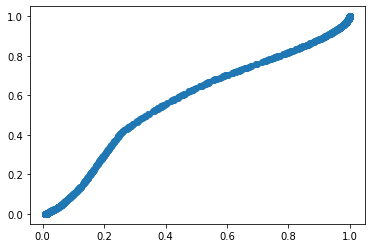

   7: TIME: 1.38 ETA: 127.88 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.00183388 0.0019632 ]]

0.28864320954732525 0.7139085970566731 [0.38579147] [0.39147029]

[[0.00019438 0.00201076]]

0.3333343372395283 0.951295548661882 [0.35832065] [0.40957633]

[[2.85743975e-05 1.25481104e-03]]

0.4480034360226597 0.8891437822944951 [0.35309219] [0.42443407]

[[2.4128474e-05 1.3253435e-03]]

0.4320474782594986 0.8725489106685865 [0.35272263] [0.42260041]

[[2.33107597e-05 1.34137048e-03]]

0.4284058221590857 0.8685916318989819 [0.35264755] [0.42218408]

[[2.31413607e-05 1.34476492e-03]]

0.42762668401046444 0.8677396971749087 [0.35263169] [0.42209538]

[[2.31055668e-05 1.34548547e-03]]

0.4274609123228524 0.8675583639834471 [0.35262832] [0.42207653]

[[2.30979719e-05 1.34563851e-03]]

0.42742568645435564 0.8675198296769041 [0.35262761] [0.42207252]

[[2.30963590e-05 1.34567102e-03]]

0.4274182031167494 0.8675116434387791 [0.35262746] [0.42207167]

[[2.30960164e-05 1.3456

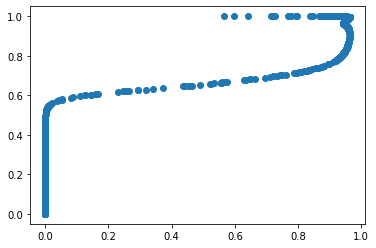

   8: TIME: 2.73 ETA: 251.38 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.01189208 0.01247507]]

0.2860820215923365 0.7186565925149179 [-0.05849315] [-0.04327569]

[[0.00464315 0.01296985]]

0.2813312031176618 0.9309742957057836 [-0.11353048] [-0.01452821]

[[0.00231064 0.01040401]]

0.3284254083571482 0.9732539308644628 [-0.13778654] [0.00832394]

[[0.00202162 0.00921644]]

0.35695072024157026 0.939424515508845 [-0.14169866] [0.01670086]

[[0.00197337 0.00888581]]

0.3661168277606631 0.9292760398062175 [-0.14227807] [0.01913025]

[[0.00197608 0.00879614]]

0.36965392790109847 0.928979366017318 [-0.14219992] [0.01996166]

[[0.00198537 0.0087604 ]]

0.3716515185285261 0.9301283897505226 [-0.1420481] [0.02038981]

[[0.00199346 0.00873952]]

0.3730094105853578 0.9311980978388689 [-0.14192051] [0.02067137]

[[0.00199961 0.00872513]]

0.3739853385024621 0.9320160604077493 [-0.14182423] [0.02087206]

[[0.00200417 0.00871473]]

0.37469723108346176 0.9326190219688644 [-0

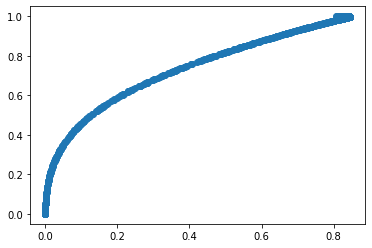

   9: TIME: 1.77 ETA: 161.18 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.04676938 0.04750712]]

0.2867218579684831 0.7111178375965718 [-0.30589071] [-0.28118718]

[[0.02813173 0.04746623]]

0.26800586969986734 0.9021123279061282 [-0.40281584] [-0.23436794]

[[0.01117812 0.03810182]]

0.28665259753650624 0.9694929284828863 [-0.47604274] [-0.18918916]

[[0.00834675 0.02911292]]

0.3398218059316706 0.8949083235262186 [-0.4922796] [-0.15924528]

[[0.0081759  0.02576144]]

0.3664865663426205 0.8843484945652452 [-0.49170239] [-0.14643131]

[[0.00851301 0.02439588]]

0.3824972603730823 0.8967270526002727 [-0.48835777] [-0.13946096]

[[0.00884547 0.02347142]]

0.39460909828832047 0.9081402746899259 [-0.48535614] [-0.13430795]

[[0.00912382 0.02277131]]

0.4040817913580604 0.9169023348008025 [-0.48290954] [-0.13030283]

[[0.00935066 0.02223541]]

0.4114884951687248 0.9235333138902445 [-0.48095146] [-0.12718468]

[[0.009533   0.02182513]]

0.41725908634667336 0.9285524573

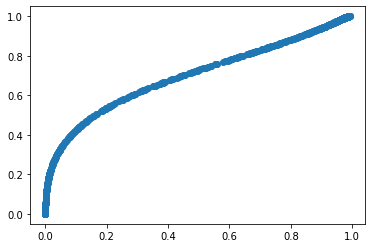

  10: TIME: 1.50 ETA: 135.18 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.13490064 0.13825922]]

0.2868574000752792 0.7238114588667944 [-0.62938068] [-0.58033749]

[[0.08197786 0.13618301]]

0.26688544423332444 0.9123729274863814 [-0.79555848] [-0.50019306]

[[0.03240571 0.10789905]]

0.2877643308286628 0.9672395650197085 [-0.91969228] [-0.42260459]

[[0.02435767 0.08016638]]

0.345129309807974 0.8901045956464045 [-0.94565511] [-0.36861032]

[[0.02437084 0.06990387]]

0.3751216851791284 0.886706231735654 [-0.94178495] [-0.34453658]

[[0.02576584 0.06522029]]

0.39469453256988274 0.9033836707090398 [-0.93390785] [-0.33012076]

[[0.02708814 0.06188384]]

0.40996423525216547 0.9174548800382182 [-0.92699894] [-0.31908435]

[[0.02821086 0.05934996]]

0.4220313483812103 0.928040938044882 [-0.92132821] [-0.31043751]

[[0.02913695 0.05742296]]

0.43149920294221195 0.9359204021002976 [-0.9167714] [-0.30370177]

[[0.0298857  0.05596102]]

0.4388688527333435 0.9417762318445

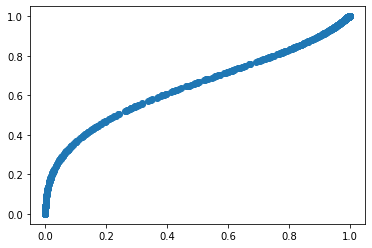

  11: TIME: 0.80 ETA: 71.33 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.20477213 0.21066689]]

0.2858748262998961 0.7139905151572122 [-0.72077969] [-0.65960259]

[[0.11761664 0.20934567]]

0.2667501744358102 0.9110924512881746 [-0.92918986] [-0.55905915]

[[0.04602732 0.16512836]]

0.2944171946568059 0.9644873933936868 [-1.07622816] [-0.46078579]

[[0.03595207 0.12636152]]

0.34849787612140615 0.8960986486442936 [-1.10387455] [-0.3985601]

[[0.03605702 0.11226029]]

0.37590160354038105 0.8936343379436062 [-1.09986533] [-0.37132182]

[[0.03785568 0.10564844]]

0.3938640760557483 0.907832855269216 [-1.09163307] [-0.35485789]

[[0.03956489 0.10090004]]

0.40790171955243243 0.9200608919545071 [-1.08433354] [-0.34220245]

[[0.04102155 0.09723203]]

0.4190916078760774 0.9294091326124274 [-1.07827921] [-0.3321711]

[[0.04223368 0.09438583]]

0.4279857587804824 0.9364879047506031 [-1.07334497] [-0.32423446]

[[0.04322686 0.09218066]]

0.43501887611310663 0.9418494589352

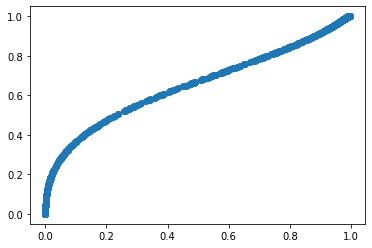

  12: TIME: 1.50 ETA: 132.21 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.22573784 0.23217698]]

0.2854483566375631 0.7260437627902104 [-0.43381366] [-0.36573913]

[[0.11444949 0.23187537]]

0.26740510962056824 0.9232020596813884 [-0.66615304] [-0.2526835]

[[0.04151081 0.17480762]]

0.31942253009826055 0.9509572898100712 [-0.80760355] [-0.13409678]

[[0.03604734 0.13441335]]

0.3755594542546305 0.9068388791291315 [-0.82159705] [-0.06883266]

[[0.03803702 0.11902752]]

0.40691012550556266 0.9188665173714149 [-0.81138912] [-0.03654177]

[[0.04080251 0.1091432 ]]

0.43102698411229357 0.9352366046700926 [-0.79965039] [-0.01256441]

[[0.04339106 0.10129064]]

0.45101940754467995 0.9477323374870693 [-0.78912114] [0.00723412]

[[0.04571034 0.09497997]]

0.4675836697245294 0.9568701016004519 [-0.78000084] [0.02359531]

[[0.04774055 0.08993822]]

0.48119223157346724 0.9635279067083694 [-0.77226406] [0.03699831]

[[0.0494817  0.08592851]]

0.49227924976177223 0.9683852042

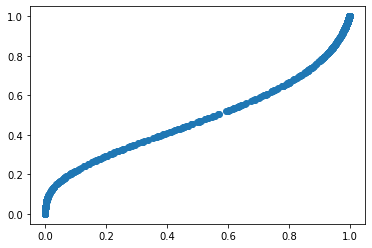

  13: TIME: 1.40 ETA: 121.68 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.25894989 0.26562202]]

0.2904687773176702 0.7146745930760494 [-0.16784549] [-0.10109406]

[[0.13761534 0.26492083]]

0.2712150601207952 0.914972323245085 [-0.4133855] [0.01977081]

[[0.03953915 0.18963217]]

0.3331836773708969 0.9323449766657681 [-0.58134855] [0.16706859]

[[0.03532218 0.13677261]]

0.3970354618828539 0.89629050229497 [-0.58934743] [0.24693052]

[[0.03892798 0.1160792 ]]

0.4335019810633801 0.9168535995564212 [-0.57323854] [0.28825809]

[[0.04267429 0.10234557]]

0.4602081401494405 0.933917226079289 [-0.55848538] [0.3181079]

[[0.04589876 0.09285357]]

0.47968491414489767 0.9454773753723866 [-0.54675594] [0.33969757]

[[0.04846719 0.08645231]]

0.4934637597279708 0.9530457966181398 [-0.53799849] [0.35481615]

[[0.05039752 0.08220144]]

0.5029788914920971 0.9579891333743187 [-0.53173129] [0.36515874]

[[0.0517896  0.07939436]]

0.5094507214278613 0.96123583615899 [-0.5273660

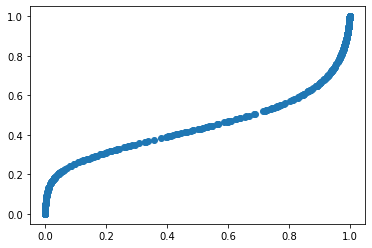

  14: TIME: 1.22 ETA: 104.58 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.35663521 0.37139493]]

0.2864696922204562 0.7131899696851474 [-0.02484067] [0.05986856]

[[0.18454611 0.36677977]]

0.26712474658695734 0.9184459285745402 [-0.3221303] [0.20401627]

[[0.04695277 0.24995955]]

0.33967393189130973 0.9123256079814723 [-0.52178967] [0.38916828]

[[0.0422248  0.17879787]]

0.39933144834412315 0.8793392329956686 [-0.52822769] [0.47807724]

[[0.04668968 0.15535269]]

0.42850612389990084 0.8995619919556306 [-0.51188462] [0.51749064]

[[0.05057711 0.14133617]]

0.44753109576485617 0.9136264722696303 [-0.49917118] [0.54276287]

[[0.05353097 0.1325941 ]]

0.4600069588140845 0.9228502439723075 [-0.49016522] [0.55916971]

[[0.05565356 0.12709599]]

0.4681557170776428 0.9289246677135125 [-0.48400016] [0.56980015]

[[0.05712187 0.12361138]]

0.47346086445259333 0.9328912654501004 [-0.47987003] [0.57667838]

[[0.05811217 0.12139122]]

0.47690392923006714 0.9354623372920395

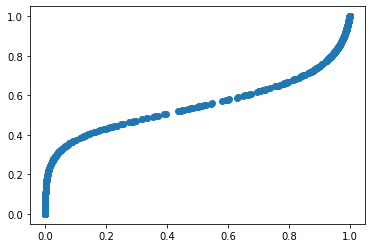

  15: TIME: 1.38 ETA: 116.95 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.51785835 0.53828416]]

0.28702483902603027 0.7017183224382854 [0.0047802] [0.1039415]

[[0.26685334 0.53316105]]

0.2676647392256332 0.9132035332232388 [-0.35338525] [0.27769428]

[[0.05982599 0.35143143]]

0.3483924399196101 0.9021792431766309 [-0.59933263] [0.51677415]

[[0.05554426 0.24894103]]

0.4075342693504664 0.8781926482617349 [-0.60207196] [0.6237596]

[[0.0617512  0.21594241]]

0.4349753411950428 0.8977004068199513 [-0.5833134] [0.66928029]

[[0.06654051 0.19788806]]

0.45117277594972827 0.9095790919858866 [-0.57035283] [0.69572089]

[[0.06977897 0.18782269]]

0.46065084609370116 0.9166511410181665 [-0.56218022] [0.71102432]



In [ ]:
aae.fit(xUnlabeledTrain,xPosTrain,validation_data=(xUnlabeledVal,xPosVal),batch_size=1024)

# Reconstructions for Mnist

In [ ]:
images = [d.numpy().reshape((28,28)) for d in decodings]


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid


fig = plt.figure(figsize=(12., 12.),)
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im,yi in zip(grid, images[:16],y_test):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_title(yi)

plt.show()